In [1]:
import os
import random

import albumentations
import cv2
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import rasterio
import tensorflow as tf

from IPython.display import HTML, display
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.initializers import glorot_normal, random_normal, random_uniform
from keras.layers import (
    Add, add, average, AveragePooling2D,
    Input, BatchNormalization, Activation, Dropout,
    LeakyReLU, UpSampling2D, Lambda, multiply, 
    Concatenate, concatenate, multiply, MaxPooling2D)
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD
from pandas_path import path
from pathlib import Path
from skimage.morphology import label

plt.style.use("ggplot")
K.set_image_data_format('channels_last')  # TF dimension ordering
kinit = 'glorot_normal'
%matplotlib inline

In [2]:
img_size = 512
smooth = 1

In [3]:
# This is where our downloaded images and metadata live locally
DATA_PATH = Path.cwd() / "training_data"
train_metadata = pd.read_csv(
    DATA_PATH / "flood-training-metadata.csv", parse_dates=["scene_start"]
)

In [4]:
#adding the path to the images and labels in the dataframe
train_metadata["feature_path"] = (str(DATA_PATH / "train_features")
    / train_metadata.image_id.path.with_suffix(".tif").path)

sources = ['change', 'extent', 'occurrence', 'recurrence', 'seasonality', 'transitions', 'nasadem']

for i in os.listdir('training_data/train_features'):
    for source in sources:
        if source in i:
            train_metadata[source] = DATA_PATH /'train_features' / i

train_metadata["label_path"] = (str(DATA_PATH / "train_labels")
    / train_metadata.chip_id.path.with_suffix(".tif").path)

In [5]:
train_metadata

,image_id,chip_id,flood_id,polarization,location,scene_start,feature_path,change,transitions,recurrence,extent,seasonality,nasadem,occurrence,label_path
0,awc00_vh,awc00,awc,vh,Bolivia,2018-02-15,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_labels...
1,awc00_vv,awc00,awc,vv,Bolivia,2018-02-15,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_labels...
2,awc01_vh,awc01,awc,vh,Bolivia,2018-02-15,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_labels...
3,awc01_vv,awc01,awc,vv,Bolivia,2018-02-15,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_labels...
4,awc02_vh,awc02,awc,vh,Bolivia,2018-02-15,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_labels...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079,wvy29_vv,wvy29,wvy,vv,UK,2019-02-15,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_labels...
1080,wvy30_vh,wvy30,wvy,vh,UK,2019-02-15,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_labels...
1081,wvy30_vv,wvy30,wvy,vv,UK,2019-02-15,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featu

# Train Test Split

In [6]:
random.seed(12) 

# Sample 3 random floods for validation set
difficult_ids = ['hxu','jja','pxs']
flood_ids = list(set(train_metadata.flood_id.unique().tolist())-set(difficult_ids))
val_flood_ids = random.sample(flood_ids, 3)
val_flood_ids 

['awc', 'qus', 'qxb']

In [7]:
test = train_metadata[train_metadata.flood_id.isin(val_flood_ids)]
train = train_metadata[~train_metadata.flood_id.isin(val_flood_ids)]

In [8]:
def get_paths_by_chip(image_level_df):
    """
    Function that takes as input the meta_dataframe
    and return a dataframe with the chip id and both path for vv and vh.
    """
    
    paths = []
    for chip, group in image_level_df.groupby("chip_id"):
        vv_path = group[group.polarization == "vv"]["feature_path"].values[0]
        vh_path = group[group.polarization == "vh"]["feature_path"].values[0]
        nasadem_path = group["nasadem"].values[0]
        change_path = group["change"].values[0]
        extent_path = group["extent"].values[0]
        occurrence_path = group["occurrence"].values[0]
        recurrence_path = group["recurrence"].values[0]
        seasonality_path = group["seasonality"].values[0]
        transitions_path = group["transitions"].values[0]
        paths.append([chip, vv_path, vh_path, nasadem_path, change_path, extent_path, occurrence_path, recurrence_path,
                      seasonality_path, transitions_path])
    return pd.DataFrame(paths, columns=["chip_id", "vv_path", "vh_path", "nasadem", "change", "extent", "occurrence",
                                        "recurrence", "seasonality", "transitions"])

In [9]:
# Separate features from labels
test_meta_x = get_paths_by_chip(test)
test_meta_y = test[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

train_meta_x = get_paths_by_chip(train)
train_meta_y = train[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

# Get images

In [10]:
from IPython.display import HTML, display
def progress(value, max=100):
    return HTML("""
        <progress value='{value}', max='{max}', style='width: 100%'> {value} </progress>
    """.format(value=value, max=max))

In [11]:
def numpy_mask(image_path):
    with rasterio.open(image_path) as img:
        return img.read(1, masked=True)

In [14]:
def get_images(feature_path, label_path):
    features = []
    labels = []
    masks = []

    #progress bar
    out1 = display(progress(0, 100), display_id=True)
    out2 = display(progress(0, 100), display_id=True)

    paths = label_path['label_path'].to_list()
    nb_cols = len(paths)
    #load labels
    for i in range(nb_cols):
        with rasterio.open(paths[i]) as lp:
            img = lp.read(1)

        #create a list of mask for missing pixels
        mask = np.zeros(img.shape, dtype=np.uint8)
        mask[np.where(img == 255)] = 0

        labels.append(ma.array(img.astype('float32'), mask = mask))
        masks.append(mask)

        out1.update(progress((i/nb_cols)*100, 100))

    #load features
    cols = ["vv_path", "vh_path", "nasadem", "change", "extent", "seasonality", "occurrence", "recurrence", "transitions"]
    nb_cols = len(feature_path)
    for row in range(nb_cols) :
        images = []
        for col in cols:
            with rasterio.open(feature_path.loc[row, col]) as img:
          #load the tif file
                if(col in ["vv_path", "vh_path"]):
              #apply transformation: clip values out of -30;0 range and map them to 0; 255 range then convert to uint8
                    images.append(ma.array(np.uint8(np.clip(img.read(1), -30, 0)*(-8.5)), mask = masks[row]))
                elif col == "nasadem":
              #clip values > 255 and converto to uint8
                    images.append(ma.array(np.uint8(np.clip(img.read(1), 0, 255)), mask = masks[row]))
                else:
              #no transformation, values are already between 0 and 255 and in uint8 format
                  images.append(ma.array(img.read(1), mask = masks[row]))
        features.append(np.stack(images, axis=-1))
        out2.update(progress((row/nb_cols)*100, 100))       
    #return len(features), len(labels)
    return np.array(features), np.array(labels)

In [15]:
train_x, train_y = get_images(train_meta_x, train_meta_y)
test_x, test_y = get_images(test_meta_x, test_meta_y)

# Image augmentations

In [16]:
random.seed(12)

transform = albumentations.Compose(
    [
        albumentations.RandomRotate90(),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.VerticalFlip(p=0.5),
        albumentations.OneOf([
            albumentations.MotionBlur(p=0.2),
            albumentations.MedianBlur(blur_limit=3, p=0.1),
            albumentations.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
    ]
)

In [17]:
train_x_aug = []
train_y_aug = []
for i in range(len(train_x)):
    t = transform(image=train_x[i], mask=train_y[i])
    train_x_aug.append(t['image'])
    train_y_aug.append(t['mask'])

train_x_aug = np.array(train_x_aug)
train_y_aug = np.array(train_y_aug)

In [18]:
train_x_final = np.concatenate((train_x, train_x_aug))
train_y_final = np.concatenate((train_y, train_y_aug))

In [19]:
train_x_final.shape

(910, 512, 512, 9)

# Loss function

In [20]:
# https://gist.github.com/wassname/7793e2058c5c9dacb5212c0ac0b18a8a
def DiceLoss_square(y_true, y_pred, smooth=1):
  #create the missing data mask
    mask = tf.math.not_equal(y_true, 255)
  #apply the mask
    y_true = tf.boolean_mask(y_true, mask)
    y_pred = tf.boolean_mask(y_pred, mask)

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(K.abs(y_true_f * y_pred_f))
    return 1-((2. * intersection + smooth) / (K.sum(K.square(y_true_f),-1) + K.sum(K.square(y_pred_f),-1) + smooth))

def DiceLoss(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return 1-((2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth))

In [21]:
def IOU_coef(y_true, y_pred):
  #create the missing data mask
    mask = tf.math.not_equal(y_true, 255)
    #apply the mask
    y_true = tf.boolean_mask(y_true, mask)
    y_pred = tf.boolean_mask(y_pred, mask)

    #make all values > 0.5 a 1 and all others a 0
    y_pred = tf.cast((y_pred > 0.5), dtype=tf.float32)

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [22]:
def tversky(y_true, y_pred, alpha = 0.75):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true, y_pred, gamma = 0.75):
    pt_1 = tversky(y_true, y_pred)
    return K.pow((1-pt_1), gamma)

## Attention Layer

2D Layers

In [23]:
def expend_as(tensor, rep,name):
    '''
    Anonymous lambda function to expand the specified axis by a factor of argument, rep.
    If tensor has shape (512,512,N), lambda will return a tensor of shape (512,512,N*rep), if specified axis=2
    '''
    my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep},  name='psi_up'+name)(tensor)
    return my_repeat


def AttnGatingBlock(x, g, inter_shape, name):
    ''' take g which is the spatially smaller signal, do a conv to get the same
    number of feature channels as x (bigger spatially)
    do a conv on x to also get same geature channels (theta_x)
    then, upsample g to be same size as x 
    add x and g (concat_xg)
    relu, 1x1 conv, then sigmoid then upsample the final - this gives us attn coefficients'''
    
    shape_x = K.int_shape(x)  # 32
    shape_g = K.int_shape(g)  # 16

    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same', name='xl'+name)(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, (1, 1), padding='same')(g)
    upsample_g = Conv2DTranspose(inter_shape, (3, 3),strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),padding='same', name='g_up'+name)(phi_g)  # 16

    concat_xg = add([upsample_g, theta_x])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same', name='psi'+name)(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = expend_as(upsample_psi, shape_x[3],  name)
    y = multiply([upsample_psi, x], name='q_attn'+name)

    result = Conv2D(shape_x[3], (1, 1), padding='same',name='q_attn_conv'+name)(y)
    result_bn = BatchNormalization(name='q_attn_bn'+name)(result)
    return result_bn


def UnetConv2D(input, outdim, is_batchnorm, name):
    x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_1')(input)
    if is_batchnorm:
        x =BatchNormalization(name=name + '_1_bn')(x)
    x = Activation('relu', name=name + '_1_act')(x)

    x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_2')(x)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_2_bn')(x)
    x = Activation('relu', name=name + '_2_act')(x)
    return x


def UnetGatingSignal(input, is_batchnorm, name):
    ''' this is simply 1x1 convolution, bn, activation '''
    shape = K.int_shape(input)
    x = Conv2D(shape[3] * 1, (1, 1), strides=(1, 1), padding="same",  kernel_initializer=kinit, name=name + '_conv')(input)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_bn')(x)
    x = Activation('relu', name = name + '_act')(x)
    return x

In [24]:
# attention gates un-net
def attn_unet(opt,input_size, lossfxn):   
    inputs = Input(shape=(input_size, input_size, 9))
    conv1 = UnetConv2D(inputs, 32, is_batchnorm=True, name='conv1')
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = UnetConv2D(pool1, 32, is_batchnorm=True, name='conv2')
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = UnetConv2D(pool2, 64, is_batchnorm=True, name='conv3')
    #conv3 = Dropout(0.2,name='drop_conv3')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = UnetConv2D(pool3, 64, is_batchnorm=True, name='conv4')
    #conv4 = Dropout(0.2, name='drop_conv4')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    center = UnetConv2D(pool4, 128, is_batchnorm=True, name='center')
    
    g1 = UnetGatingSignal(center, is_batchnorm=True, name='g1')
    attn1 = AttnGatingBlock(conv4, g1, 128, '_1')
    up1 = concatenate([Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(center), attn1], name='up1')
    
    g2 = UnetGatingSignal(up1, is_batchnorm=True, name='g2')
    attn2 = AttnGatingBlock(conv3, g2, 64, '_2')
    up2 = concatenate([Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up1), attn2], name='up2')

    g3 = UnetGatingSignal(up1, is_batchnorm=True, name='g3')
    attn3 = AttnGatingBlock(conv2, g3, 32, '_3')
    up3 = concatenate([Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up2), attn3], name='up3')

    up4 = concatenate([Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up3), conv1], name='up4')
    out = Conv2D(1, (1, 1), activation='sigmoid',  kernel_initializer=kinit, name='final')(up4)
    
    model = Model(inputs=[inputs], outputs=[out])
    model.compile(optimizer=opt, loss=lossfxn, metrics=[IOU_coef])
    return model

In [25]:
sgd = SGD(learning_rate=0.01, momentum=0.90, decay=1e-6)
adam = Adam(learning_rate=1e-4)

In [29]:
input_img = Input((img_size, img_size, 9), name='img')
model = attn_unet(adam, img_size, DiceLoss_square)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 9  0           []                               
                                )]                                                                
                                                                                                  
 conv1_1 (Conv2D)               (None, 512, 512, 32  2624        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_1_bn (BatchNormalization  (None, 512, 512, 32  128        ['conv1_1[0][0]']                
 )                              )                                                             

In [30]:
MODEL_NAME = "test_tensorflow_attn_unet.h5"

In [31]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)
    # ModelCheckpoint('/models/' + MODEL_NAME, verbose=1, save_best_only=True, save_weights_only=False)
]

In [32]:
print(type(train_x_final[0,0,0,8]), type(train_y[0,0,0]))
print(type(test_x[0,0,0,0]), type(test_y[0,0,0]))

<class 'numpy.uint8'> <class 'numpy.float32'>
<class 'numpy.uint8'> <class 'numpy.float32'>


In [33]:
print("max train_x:", np.amax(train_x), "min train_x:", np.amin(train_x))
print("max train_x_aug:", np.amax(train_x_aug), "min train_x_aug:", np.amin(train_x_aug))
print("max test_x:", np.amax(test_x), "min test_x:", np.amin(test_x))
print("max train_y:", np.amax(train_y), "min train_y:", np.amin(train_y))
print("max test_y:", np.amax(test_y), "min test_y:", np.amin(test_y))

max train_x: 255 min train_x: 0
max train_x_aug: 255 min train_x_aug: 0
max test_x: 255 min test_x: 0
max train_y: 255.0 min train_y: 0.0
max test_y: 255.0 min test_y: 0.0


In [84]:
results = model.fit(train_x_final, train_y_final, batch_size=8, epochs=100, callbacks=callbacks,
                    validation_data=(test_x, test_y))

Epoch 1/100
111/111 [==============================] - 34s 284ms/step - loss: 0.3880 - IOU_coef: 0.4585 - val_loss: 0.7548 - val_IOU_coef: 0.0996 - lr: 1.0000e-04
Epoch 2/100
111/111 [==============================] - 31s 284ms/step - loss: 0.2423 - IOU_coef: 0.5964 - val_loss: 0.4876 - val_IOU_coef: 0.3924 - lr: 1.0000e-04
Epoch 3/100
111/111 [==============================] - 32s 287ms/step - loss: 0.2294 - IOU_coef: 0.6037 - val_loss: 0.3694 - val_IOU_coef: 0.4732 - lr: 1.0000e-04
Epoch 4/100
111/111 [==============================] - 32s 289ms/step - loss: 0.2200 - IOU_coef: 0.6190 - val_loss: 0.3342 - val_IOU_coef: 0.5402 - lr: 1.0000e-04
Epoch 5/100
111/111 [==============================] - 32s 290ms/step - loss: 0.2080 - IOU_coef: 0.6350 - val_loss: 0.3888 - val_IOU_coef: 0.4246 - lr: 1.0000e-04
Epoch 6/100
111/111 [==============================] - 32s 291ms/step - loss: 0.2124 - IOU_coef: 0.6226 - val_loss: 0.3927 - val_IOU_coef: 0.4569 - lr: 1.0000e-04
Epoch 7/100
111/111 [=

With difficult id in train (train IoU):
- IOU = 0.6394 Unet with attention + tversky loss + adam learning_rate=1e-3 + alpha = 0.75 
- IOU = 0.661 Unet with attention + tversky loss + adam learning_rate=1e-4 + alpha = 0.75
- IOU = 0.6209 Unet with attention +  tversky loss + adam learning_rate=1e-4 + alpha = 0.8
- IOU = 0.5939 Unet with attention + tversky loss + adam learning_rate=1e-4 + alpha = 0.5
- IOU = 0.6115 Unet with attention + DICE loss + adam
- IOU = 0.5788 Unet with attention + DICE loss + sgd

Without difficult id in train (train IoU): (still have to automate it though) (old)
- IOU = 0.6555 Unet with attention + tversky loss + adam + learning_rate=1e-4 + alpha = 0.75
- IOU = 0.6554 Unet with attention + tversky loss + learning_rate=5e-4 + alpha 0.75 
- IOU = 0.6058 Unet with attention + tversky loss + learning_rate=1e-3 + alpha 0.75 
- IOU = 0.7462 Unet with attention + learning_rate=1e-4 + alpha 0.75 + dice_square

Difficult chips: https://github.com/drivendataorg/stac-overflow/blob/main/3rd_Place/01-ewl-stac.ipynb
hxu, jja, pxs --> keep in training

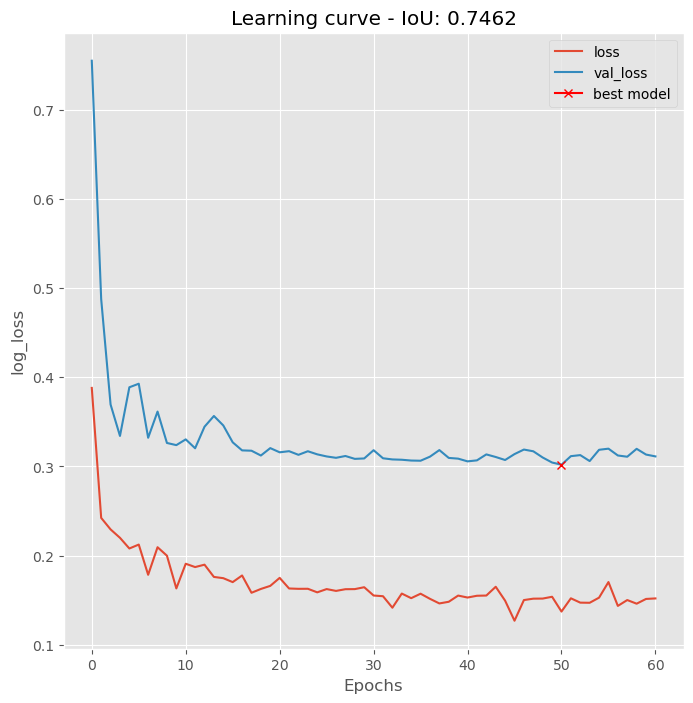

In [86]:
plt.figure(figsize=(8, 8))
plt.title(f"Learning curve - IoU: {round(max(results.history['IOU_coef']), 4)}")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()